
# RNN: Sale Time Series Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. 

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html


In [2]:
df = pd.read_csv('../Data/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.columns = ['Sales']

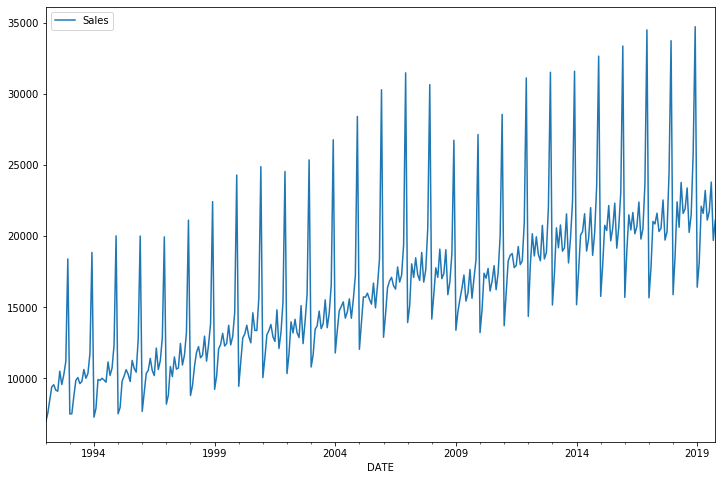

In [5]:
df.plot(figsize=(12,8))

## Train Test Split

In [6]:
len(df)

334

Data is monthly, let's forecast 1.5 years into the future.

In [7]:
len(df)- 18

316

In [8]:
test_size = 18

In [9]:
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [12]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Scale Data

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 12 # I choose 12 month as it create a year that is a one cycle
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [19]:
# What does the first batch look like?
X,y = generator[0]

In [20]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


### Create the Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [22]:
# using one feature in our time series
n_features = 1
n_input=12

In [23]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [27]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [28]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/20
304/304 [==============================] - 5s 15ms/step - loss: 0.0288 - val_loss: 0.0076
Epoch 2/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0188 - val_loss: 0.0110
Epoch 3/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0123 - val_loss: 0.0057
Epoch 4/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0047 - val_loss: 0.0062
Epoch 5/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 6/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0018 - val_loss: 0.0083
Epoch 7/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0017 - val_loss: 0.0047


In [29]:
losses = pd.DataFrame(model.history.history)

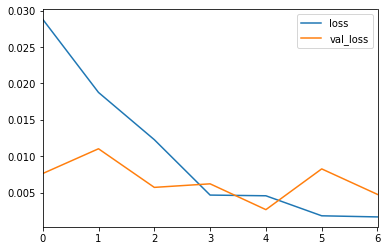

In [30]:
losses.plot()

## Evaluate on Test Data

In [31]:
first_eval_batch = scaled_train[-length:]

In [32]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [33]:
model.predict(first_eval_batch)

array([[0.58267283]], dtype=float32)

In [34]:
scaled_test[0]

array([0.61087714])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

In [35]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [36]:
true_predictions = scaler.inverse_transform(test_predictions)

In [37]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\Yasser B\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22987.140551
2018-06-01,21589,21657.399941
2018-07-01,21919,21943.287777
2018-08-01,23381,24086.931041
2018-09-01,20260,21179.880438
2018-10-01,21473,21860.169241
2018-11-01,25831,26309.204296
2018-12-01,34706,39511.242757
2019-01-01,16410,17564.486803


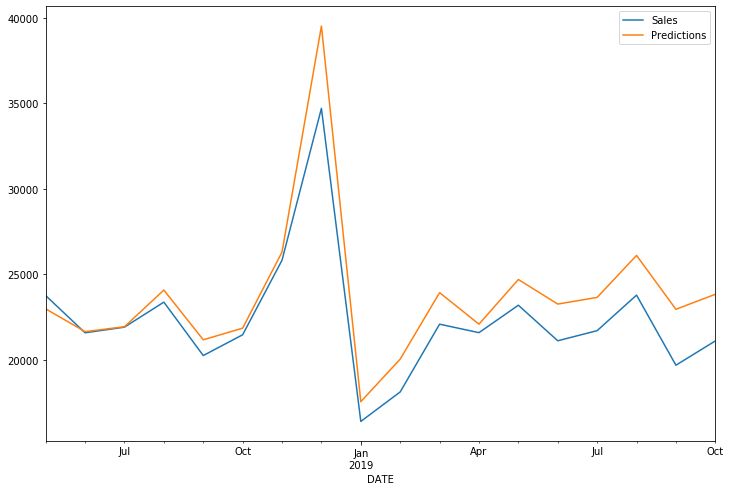

In [39]:
test.plot(figsize=(12,8))

# Retrain and Forecasting

In [40]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [41]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [42]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

  ...
    to  
  ['...']
Train for 322 steps
Epoch 1/8
322/322 [==============================] - 5s 15ms/step - loss: 0.0226
Epoch 2/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0157
Epoch 3/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0099
Epoch 4/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0032
Epoch 5/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0027
Epoch 6/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0027
Epoch 7/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0020
Epoch 8/8
322/322 [==============================] - 4s 12ms/step - loss: 0.0016


In [43]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [44]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [45]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [46]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [47]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [48]:
forecast_df

,Forecast
2019-11-01,26786.505445
2019-12-01,38637.296368
2020-01-01,16698.954384
2020-02-01,18360.740641
2020-03-01,22130.343885
2020-04-01,21853.250906
2020-05-01,23540.128033
2020-06-01,21615.625604
2020-07-01,22246.509214
2020-08-01,24372.787684


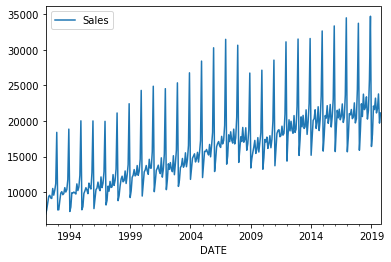

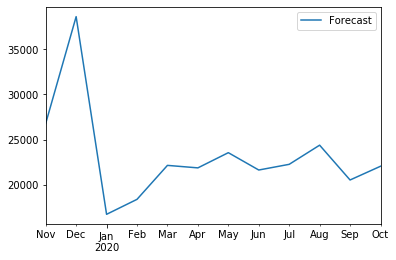

In [49]:
df.plot()
forecast_df.plot()

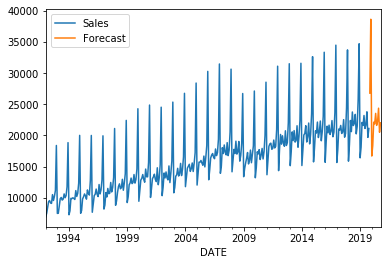

In [50]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576, 611)

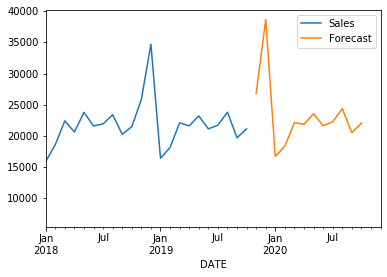

In [51]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')

# Done!